In [1]:
try:
    from fastlane_bot.tools.cpc import CPCContainer, ConstantProductCurve as CPC, CurveBase
    from fastlane_bot.tools.optimizer import MargPOptimizer, PairOptimizer
    from fastlane_bot.testing import *

except:
    from tools.cpc import CPCContainer, ConstantProductCurve as CPC, CurveBase
    from tools.optimizer import MargPOptimizer, PairOptimizer
    from tools.testing import *

from math import sqrt
from copy import deepcopy
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPCContainer))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(MargPOptimizer))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(PairOptimizer))

plt.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize'] = [12,6]
# from fastlane_bot import __VERSION__
# require("3.0", __VERSION__)

imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require, Timer
CPCContainer v3.4 (23/Jan/2024)
ConstantProductCurve v3.4 (23/Jan/2024)
MargPOptimizer v5.2 (15/Sep/2023)
PairOptimizer v6.0.1 (21/Sep/2023)


# Optimization Methods [NBTest055]

Note: using an existing CPCContainer object `CC`, the curves can be extracted as dict using the command below

    CURVES = [c.asdict() for c in CC]
    

The below three curves are one POL curve (extremely levered; it is originally fixed price) and two Uniswap v3 curves. On those curves the high dimensional gradient descent algo fails because it ends up on a plateau.

We are here creating the following sets of curves

- `CC` based on `CURVES` the curves paramater set which are levered curves where the gradient descent optimization algorithm failed

- `CCn` is `CC` plus a full range curve removing the no-man's land

- `CCul` is a set of unlevered curves where convergence should not be a problem at all


### `CC` (complex levered curves)

In [2]:
CURVES = [

# POL Curve
{
  'k': 6.157332844764952e+20,
  'x': 615733222.5892723,
  'x_act': 0,
  'y_act': 100000.0,
  'alpha': 0.5,
  'pair': 'WETH/DAI', # WETH-6Cc2/DAI-1d0F
  'cid': '0x33ed',
    #     0x33ed451d5c7b7a76266b8cdfab030f6de8143fcfbdcd08dabeed0de8d684b4de
  'fee': 0.0,
  'descr': 'bancor_pol DAI-1d0F/ETH-EEeE 0.000',
  'constr': 'carb',
  'params': {'exchange': 'bancor_pol',
   'tknx_dec': 18,
   'tkny_dec': 18,
   'tknx_addr': '0x6B175474E89094C44Da98b954EedeAC495271d0F',
   'tkny_addr': '0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE',
   'blocklud': 18121620,
   'y': 100000.0,
   'yint': 100000.0,
   'A': 0,
   'B': 40.29987368093254,
   'pa': 1624.0799811071013,
   'pb': 1624.0799811071013}},
 
# Uniswap v3 Curve 1
 {
  'k': 1147678924959.0112,
  'x': 42728400.31211105,
  'x_act': 7575.552803896368,
  'y_act': 8.665306719478394,
  'alpha': 0.5,
  'pair': 'DAI/WETH', # DAi-1d0F/WETH-6Cc2
  'cid': '0xb1d8',
    #     0xb1d8cd62f75016872495dae3e19d96e364767e7d674488392029d15cdbcd7b34',
  'fee': 0.0005,
  'descr': 'uniswap_v3 DAI-1d0F/WETH-6Cc2 500',
  'constr': 'pkpp',
  'params': {'exchange': 'uniswap_v3',
   'tknx_dec': 18,
   'tkny_dec': 18,
   'tknx_addr': '0x6B175474E89094C44Da98b954EedeAC495271d0F',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18121789,
   'L': 1071297.7760450225}},
    

# Uniswap v3 Curve 2
{
  'k': 1541847511355.546,
  'x': 49517090.33542573,
  'x_act': 99496.94394361228,
  'y_act': 30.763865271412214,
  'alpha': 0.5,
  'pair': 'DAI/WETH', # DAi-1d0F/WETH-6Cc2
  'cid': '0xae2b',
      #  '0xae2b487dff467a33b88e5a4e6874f91ee212886979f673dd18d3e0396862112f',
  'fee': 0.003,
  'descr': 'uniswap_v3 DAI-1d0F/WETH-6Cc2 3000',
  'constr': 'pkpp',
  'params': {'exchange': 'uniswap_v3',
   'tknx_dec': 18,
   'tkny_dec': 18,
   'tknx_addr': '0x6B175474E89094C44Da98b954EedeAC495271d0F',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18121689,
   'L': 1241711.5250151888}}
]
CC = CPCContainer.from_dicts(CURVES)

Those are starting prices consistent with those curves.

In [3]:
PRICES = {
    'DAI':  0.0006286424878113893, 
    'WETH': 1,
}
PRICE0 = PRICES["WETH"]/PRICES["DAI"]
PRICE0

1590.7292608895832

### `CCn` (normalized curve set)

This curve set contains an additional constant product curve that removes the no-man's land between the levered curves and where gradient descent therefore converges

In [4]:
cnorm = CPC.from_pk(p=PRICE0, k=PRICE0*CC[0].x, pair="WETH/DAI", cid="normalizer")
CCn = CPCContainer([c for c in CC]+[cnorm])

### `CCul` (simple unlevered curves)

This is a very simple set of unlevered curver where convergence should never be a problem.

In [5]:
CCul = CPCContainer([
    CPC.from_pk(p=1500, k=1500*100, pair="WETH/DAI", cid="c1500"),
    CPC.from_pk(p=1600, k=1600*100, pair="WETH/DAI", cid="c1600")
])

### `CCas` (asymmetric unlevered curves)

We are generating asymmetric curves that have an arbitrage opportunity. `CCas2` is a single pair that exhibits the arbitrage, `CCas3` requires triangle optimization.

In [6]:
ETA25, ETA75 = 1/3, 3
CCas2 = CPCContainer([
    CPC.from_xyal(x=10, y=2000/ETA25*10, alpha=0.25, pair="WETH/DAI", cid="c2000-0.25"),
    CPC.from_xyal(x=10, y=2500/ETA75*10, alpha=0.75, pair="WETH/DAI", cid="c2500-0.75"),
])

In [7]:
CCas2[0].x, CCas2[0].tknx, CCas2[0].y, CCas2[0].tkny, CCas2[0].p

(10, 'WETH', 59999.99999999996, 'DAI', 1999.9999999999986)

In [8]:
CCas2[1].x, CCas2[1].tknx, CCas2[1].y, CCas2[1].tkny, CCas2[1].p

(10, 'WETH', 8333.33333333333, 'DAI', 2499.999999999999)

In [9]:
CCas2[0].eta

0.3333333333333333

## Curve definitions

Here we are asserting properties of the curves that they are meant to have; should really never fail unless something goes horribly wrong

In [10]:
assert iseq(CCas2[0].x, 10)
assert CCas2[0].tknx == "WETH"
assert iseq(CCas2[0].y, 60000)
assert CCas2[0].tkny == "DAI"
assert iseq(CCas2[0].eta, ETA25)
assert iseq(CCas2[0].p, 2000)

In [11]:
assert iseq(CCas2[1].x, 10)
assert CCas2[1].tknx == "WETH"
assert iseq(CCas2[1].y, 25000/3)
assert CCas2[1].tkny == "DAI"
assert iseq(CCas2[1].eta, ETA75)
assert iseq(CCas2[1].p, 2500)

## MargPOptimizer current

Uses the current margp optimizer which uses $d \log p ~ 0$ as criterium and that can fail on certain formations of levered curves (when the price ends up on no-mans land)
### Setup

In [12]:
#help(MargPOptimizer)

### Unlevered curves `CCul`

In [13]:
Oul = MargPOptimizer(curves=CCul)
assert len(Oul.curves) == len(CCul)

In [14]:
r = Oul.optimize("WETH")
assert r.error is None
assert r.method == "margp"
assert r.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert iseq(r.result, -0.005204267821271813)
assert iseq(r.p_optimal_t[0], 0.0006449934107164284)
assert iseq(r.dtokens_t[0], -4.737194103654474e-08)
r

CPCArbOptimizer.MargpOptimizerResult(result=-0.005204267821271813, time=0.0003368854522705078, method='margp', targettkn='WETH', p_optimal_t=(0.0006449934107164284,), dtokens_t=(-4.737194103654474e-08,), tokens_t=('DAI',), errormsg=None)

the original curves are 1500 and 1600, so ~1550 is right in the middle

In [15]:
assert iseq(1/r.p_optimal_t[0], 1550.4034357331604)
1/r.p_optimal_t[0]

1550.4034357331604

this process converged -- the aggregate change in DAI amount < 1e-5

In [16]:
assert abs(r.dtokens["DAI"] < 1e-5)
assert r.dtokens["WETH"] < 0
assert iseq(r.dtokens["WETH"], -0.005204267821271813)
r.dtokens

{'WETH': -0.005204267821271813, 'DAI': -4.737194103654474e-08}

there is some trading going on

In [17]:
v = r.dxvecvalues(asdict=True)
assert iseq(v["c1500"]["DAI"], 249.9349296963901)
assert iseq(v["c1600"]["WETH"], 0.15868818867025603)
v

{'c1500': {'WETH': -0.16389245649152784, 'DAI': 249.9349296963901},
 'c1600': {'WETH': 0.15868818867025603, 'DAI': -249.93492974376204}}

### Normalized curves `CCn`

In [18]:
On  = MargPOptimizer(curves=CCn)
assert len(On.curves) == len(CC)+1

In [19]:
r = On.optimize("WETH")
assert r.error is None
assert r.method == "margp"
assert r.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert iseq(r.result, -1.244345098228223)
assert iseq(r.p_optimal_t[0], 0.00062745798800732)
assert iseq(r.dtokens_t[0], -1.9371509552001953e-06, eps=0.1)
# assert iseq(r.dtokens_t[0], -1.9371509552001953e-06, eps=0.01)     # FAILS ON GITHUB
# assert iseq(r.dtokens_t[0], -1.9371509552001953e-06, eps=0.001)    # FAILS ON GITHUB
# assert iseq(r.dtokens_t[0], -1.9371509552001953e-06, eps=0.0001)   # FAILS ON GITHUB
r

CPCArbOptimizer.MargpOptimizerResult(result=-1.244345098228223, time=0.0006251335144042969, method='margp', targettkn='WETH', p_optimal_t=(0.00062745798800732,), dtokens_t=(-1.9371509552001953e-06,), tokens_t=('DAI',), errormsg=None)

the original curves are 1500 and 1600, so ~1550 is right in the middle

In [20]:
assert iseq(1/r.p_optimal_t[0], 1593.7322005825413, eps=0.001)
1/r.p_optimal_t[0]

1593.7322005825413

this process converged -- the aggregate change in DAI amount < 1e-5

In [21]:
assert abs(r.dtokens["DAI"] < 1e-5)
assert r.dtokens["WETH"] < 0
assert iseq(r.dtokens["WETH"], -1.244345098228223)
r.dtokens

{'WETH': -1.244345098228223, 'DAI': -1.9371509552001953e-06}

there is some trading going on

In [22]:
v = r.dxvecvalues(asdict=True)
v

{'0x33ed': {'WETH': 61.57332217693329, 'DAI': -100000.0},
 '0xb1d8': {'DAI': 13789.132085457444, 'WETH': -8.665306719478394},
 '0xae2b': {'DAI': 48971.003532998264, 'WETH': -30.763865271412214},
 'normalizer': {'WETH': -23.388495284270903, 'DAI': 37239.86437960714}}

### Asymmetric curves `CCas2` and `CCas3`

In [23]:
O = MargPOptimizer(curves=CCas2)
assert len(O.curves) == len(CCas2)

In [24]:
r = O.optimize("WETH", params={"pstart": {"WETH": 2400, "DAI": 1}})
assert r.error is None
assert r.method == "margp"
assert r.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert iseq(r.result, -0.048636442623132936, eps=1e-3)
assert iseq(r.p_optimal_t[0], 0.0004696831634035269, eps=1e-3)
assert iseq(r.dtokens_t[0], -7.3569026426412165e-09, eps=0.1)

### Failing optimization process `CC`

In [25]:
O = MargPOptimizer(curves=CC)
assert len(O.curves) == len(CC)

In [26]:
r = O.optimize("WETH")
assert r.error is None
assert r.method == "margp"
assert r.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert iseq(r.result, 22.14415018604268)
assert iseq(r.p_optimal_t[0], 0.0006273686958774544)
assert iseq(r.dtokens_t[0], -37239.86438154429)
r

CPCArbOptimizer.MargpOptimizerResult(result=22.14415018604268, time=0.0004968643188476562, method='margp', targettkn='WETH', p_optimal_t=(0.0006273686958774544,), dtokens_t=(-37239.86438154429,), tokens_t=('DAI',), errormsg=None)

Here we show that the final price is not the same as the initial one, but also not totally crazy (this calculation has not converged but is stuck on a plateau)

In [27]:
PRICES, r.p_optimal

({'DAI': 0.0006286424878113893, 'WETH': 1},
 {'DAI': 0.0006273686958774544, 'WETH': 1.0})

In [28]:
1/r.p_optimal_t[0], PRICES["WETH"]/PRICES["DAI"]

(1593.959033294407, 1590.7292608895832)

The `result` is the amount of target token extracted. Note that this assumes that the algo has converged which it has not in this case. The `dtokens` property shows the _aggregate_ change in tokens, and it _should_ be zero for everything but the target token WETH which is not the case here.

In [29]:
assert r.result == r.dtokens["WETH"]
r.result

22.14415018604268

In [30]:
r.dtokens

{'WETH': 22.14415018604268, 'DAI': -37239.86438154429}

`dxdyvalues` and `dxvecvalues` show the changes of the respective curves. For standard two-asset curves they are equivalent, just in a different format; for three+ asset curves only dxvecvalues is defined

In [31]:
r.dxdyvalues(asdict=True)

{'0x33ed': (61.57332217693329, -100000.0),
 '0xb1d8': (13789.132085457444, -8.665306719478394),
 '0xae2b': (48971.003532998264, -30.763865271412214)}

In [32]:
r.dxvecvalues(asdict=True)

{'0x33ed': {'WETH': 61.57332217693329, 'DAI': -100000.0},
 '0xb1d8': {'DAI': 13789.132085457444, 'WETH': -8.665306719478394},
 '0xae2b': {'DAI': 48971.003532998264, 'WETH': -30.763865271412214}}

This shows that the algorithm **has not converged** -- this number (the net flow of DAI; note that the target token here is WETH) should be zero!

In [33]:
s_DAI = sum(x["DAI"] for x in r.dxvecvalues(asdict=True).values())
assert iseq(s_DAI, r.dtokens["DAI"])
s_DAI

-37239.86438154429

This number is not expected to be zero as the profit is being extracted in WETH

In [34]:
s_WETH = sum(x["WETH"] for x in r.dxvecvalues(asdict=True).values())
assert iseq(s_WETH, r.dtokens["WETH"])
s_WETH

22.14415018604268

## PairOptimizer vs MarpP

PairOptimizer is a new optimization method that uses bisection instead of gradient descent. It is a bit slower, but importantly it is robust against the no-man's land problem of the gradient descent

### Setup

### Unlevered curves `CCul`

In [35]:
Oul = PairOptimizer(curves=CCul)
Oul_mp = MargPOptimizer(curves=CCul)
assert len(Oul.curves) == len(CCul)

Unlevered curves converged nicely in the margp (gradient descent) optimizer, and they are converging nicely here; the results are very close together (better than 1e-5)

In [36]:
r   = Oul.optimize("WETH")
rmp = Oul_mp.optimize("WETH")
assert r.error is None
assert rmp.error is None
assert r.method   == "margp-pair"
assert rmp.method == "margp"
assert r.targettkn == "WETH" 
assert rmp.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert rmp.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert rmp.dtokens["WETH"] < 0
assert iseq(r.p_optimal_t[0], 0.0006449934107144566)
assert iseq(rmp.p_optimal_t[0], 0.0006449934107164284)
assert r.result/rmp.result-1 < 1e-5
r, rmp, r.result/rmp.result-1

(CPCArbOptimizer.MargpOptimizerResult(result=-0.00520426785183048, time=0.0011801719665527344, method='margp-pair', targettkn='WETH', p_optimal_t=(0.000644993410714457,), dtokens_t=(3.637978807091713e-12,), tokens_t=('DAI',), errormsg=None),
 CPCArbOptimizer.MargpOptimizerResult(result=-0.005204267821271813, time=0.00024819374084472656, method='margp', targettkn='WETH', p_optimal_t=(0.0006449934107164284,), dtokens_t=(-4.737194103654474e-08,), tokens_t=('DAI',), errormsg=None),
 5.871847452709744e-09)

It is notable that the bisection algorithm is **six times slower** than the gradient descent

In [37]:
r.time/rmp.time

4.755043227665706

the optimal price here is very very close: 1e-12

In [38]:
assert r.p_optimal_t[0]/rmp.p_optimal_t[0]-1 < 1e-8
r.p_optimal_t[0]/rmp.p_optimal_t[0]-1

-3.056443986793056e-12

Here we show that (a) the DAI transfer is de-minimis and close enough to zero, and more importantly, that (b) both our methods give essentially the same result as to how much ETH can be obtained from the arb

In [39]:
assert r.dtokens["DAI"] < 1e-5
assert rmp.dtokens["DAI"] < 1e-5
assert r.dtokens["WETH"]/rmp.dtokens["WETH"]-1 < 1e-5
r.dtokens, rmp.dtokens, r.dtokens["WETH"]/rmp.dtokens["WETH"]-1

({'WETH': -0.00520426785183048, 'DAI': 3.637978807091713e-12},
 {'WETH': -0.005204267821271813, 'DAI': -4.737194103654474e-08},
 5.871847452709744e-09)

### Asymmetric curves `CCas2` and `CCas3`

#### `CCas2`

In [40]:
O = PairOptimizer(curves=CCas2)
Omp = MargPOptimizer(curves=CCas2)
assert len(O.curves) == len(CCas2)
assert len(Omp.curves) == len(O.curves)

In [41]:
r = O.optimize("WETH")
rmp = Omp.optimize("WETH")
assert r.error is None
assert r.method == "margp-pair"
assert r.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert iseq(r.result, -0.048636442623132936, eps=1e-3)
assert iseq(r.result, rmp.result, eps=1e-3)
assert r.result != rmp.result # numerically should not converged to same
assert iseq(r.p_optimal_t[0], 0.0004696831634035269, eps=1e-3)
assert iseq(r.dtokens["WETH"], -0.04863644262652045, eps=1e-3)
assert iseq(r.dtokens["WETH"], rmp.dtokens["WETH"], eps=1e-3)
assert iseq(0, r.dtokens["DAI"], eps=1e-6)
assert iseq(0, rmp.dtokens["DAI"], eps=1e-6)
assert abs(r.dtokens["DAI"] - rmp.dtokens["DAI"]) < 1e-6
assert r.dtokens_t == (r.dtokens["DAI"],)
assert rmp.dtokens_t == (rmp.dtokens["DAI"],)
assert r.tokens_t == ('DAI',)
assert rmp.tokens_t == ('DAI',)

#### `CCas3` [TODO]

### Normalized curves `CCn`

In [42]:
On = PairOptimizer(curves=CCn)
On_mp = MargPOptimizer(curves=CCn)
assert len(On.curves) == len(CC)+1

In [43]:
r = On.optimize("WETH")
rmp = On_mp.optimize("WETH")
assert r.error is None
assert rmp.error is None
assert r.method   == "margp-pair"
assert rmp.method == "margp"
assert r.targettkn == "WETH" 
assert rmp.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert rmp.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert rmp.dtokens["WETH"] < 0
assert iseq(r.p_optimal_t[0], 0.0006274579880072543)
assert iseq(rmp.p_optimal_t[0], 0.00062745798800732)
assert r.result/rmp.result-1 < 1e-5
r, rmp, r.result/rmp.result-1

(CPCArbOptimizer.MargpOptimizerResult(result=-1.2443450994433078, time=0.003554105758666992, method='margp-pair', targettkn='WETH', p_optimal_t=(0.0006274579880072587,), dtokens_t=(0.0,), tokens_t=('DAI',), errormsg=None),
 CPCArbOptimizer.MargpOptimizerResult(result=-1.244345098228223, time=0.0008661746978759766, method='margp', targettkn='WETH', p_optimal_t=(0.00062745798800732,), dtokens_t=(-1.9371509552001953e-06,), tokens_t=('DAI',), errormsg=None),
 9.764855590788102e-10)

### Optimization process `CC` (fails in full margp)

In [44]:
O = PairOptimizer(curves=CC)
O_mp   = MargPOptimizer(curves=CC)
assert len(O.curves) == len(CC)

In [45]:
r = O.optimize("WETH")
rmp = O_mp.optimize("WETH")
assert r.error is None
assert rmp.error is None
assert r.method   == "margp-pair"
assert rmp.method == "margp"
assert r.targettkn == "WETH" 
assert rmp.targettkn == "WETH"
assert r.tokens_t == ('DAI',)
assert rmp.tokens_t == ('DAI',)
assert r.dtokens["WETH"] < 0
assert not rmp.dtokens["WETH"] < 0 # FAILS!
assert iseq(r.p_optimal_t[0], 0.0006157332379890538)
assert iseq(rmp.p_optimal_t[0], 0.0006273686958774544)
assert r.result/rmp.result-1 < 1e-5
r, rmp, r.result/rmp.result-1

(CPCArbOptimizer.MargpOptimizerResult(result=-0.7856729741288291, time=0.0035212039947509766, method='margp-pair', targettkn='WETH', p_optimal_t=(0.0006157332379890483,), dtokens_t=(0.00012040883302688599,), tokens_t=('DAI',), errormsg=None),
 CPCArbOptimizer.MargpOptimizerResult(result=22.14415018604268, time=0.00044798851013183594, method='margp', targettkn='WETH', p_optimal_t=(0.0006273686958774544,), dtokens_t=(-37239.86438154429,), tokens_t=('DAI',), errormsg=None),
 -1.0354799334148317)

This now converges fine (note as we see below we need an eps parameter of about 1e-10, and also not that we can't go much higher because in this case it gets stuck, probably because of float precision.

In [46]:
r.dtokens, r.dtokens["WETH"]*PRICE0

({'WETH': -0.7856729741288291, 'DAI': 0.00012040883302688599},
 -1249.7929894368729)

We see that accuracy at eps=1e-6 is not that great, but at 1e-10 it is very good; also it seems that by and large the runtime does not really depend on the precision parameter here, so we go for 1e-10 throughout [not you can't go for higher precision as it then never returns, probably because of float accuracy issues]

In [47]:
r06 = O.optimize("WETH", params={"eps":1e-6})
r08 = O.optimize("WETH", params={"eps":1e-8})
r10 = O.optimize("WETH", params={"eps":1e-10})
r06.dtokens, r08.dtokens, r10.dtokens

({'WETH': 22.14415018604268, 'DAI': -37239.86438154429},
 {'WETH': -1.0643622393799888, 'DAI': 452.6137678697705},
 {'WETH': -0.7965248341752158, 'DAI': 17.624510057270527})

In [48]:
[r10.time/r06.time, r08.time/r06.time]

[2.210240963855422, 0.854066265060241]

## MargPOptimizer new TODO

this is still on the todo lost, but does not have high priority; the new margp optimizer will have a different convergence criterium [p ~ 0 rather than d log p ~ 0]. This will not help in terms of convergence on a plateau -- a gradient algorithm can not recover from f'(x) = 0 -- but it will allow identifying instances of non convergence.

### Setup

In [49]:
pass

In [50]:
# Oul = PairOptimizer(curves=CCul)
# On  = PairOptimizer(curves=CCn)
# O0  = PairOptimizer(curves=CC0)
# O   = PairOptimizer(curves=CC)
# assert len(On.curves) == len(CC)+1
# assert len(O0.curves) == len(CC)
# assert len(O.curves) == len(CC)

### Unlevered curves `CCul`

### Normalized curves `CCn`

### Failing optimization process `CC`

## Charts [NOTEST]

pair = DAI/WETH


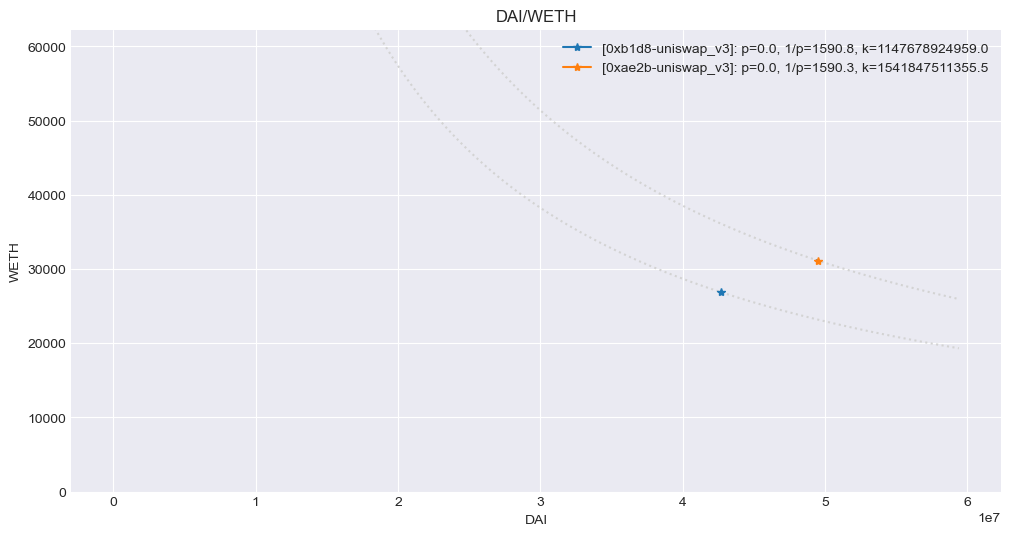

pair = WETH/DAI


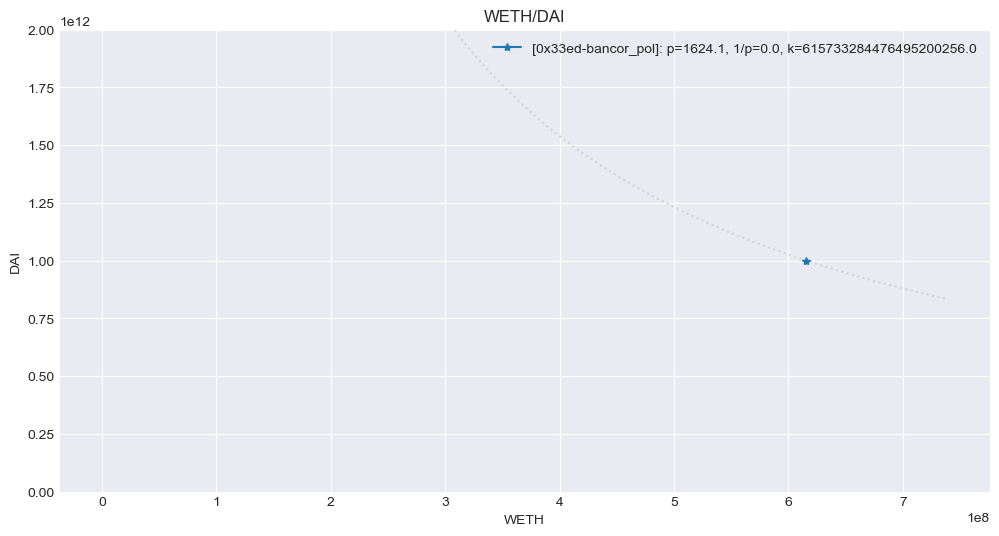

In [51]:
CC.plot()

pair = WETH/DAI


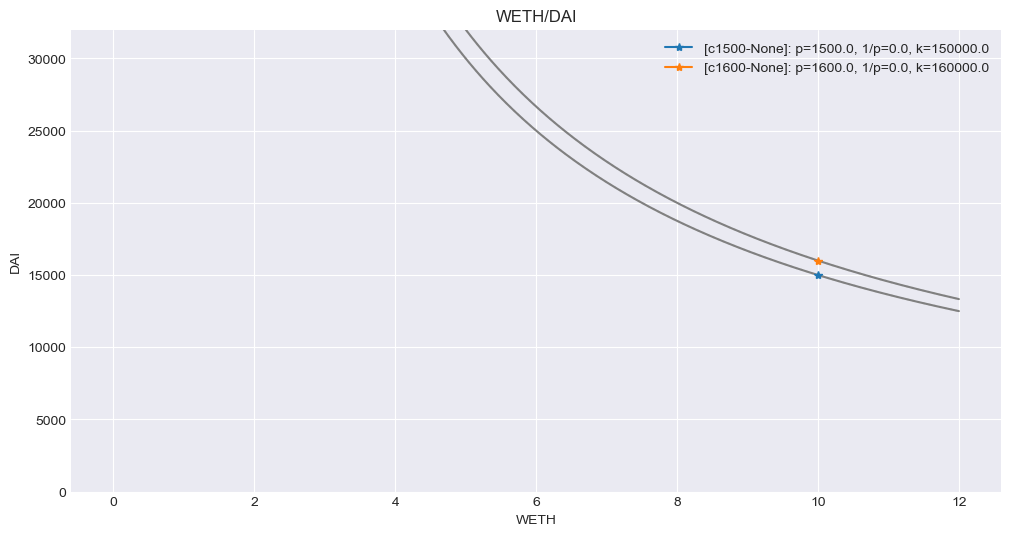

In [52]:
CCul.plot()

pair = DAI/WETH


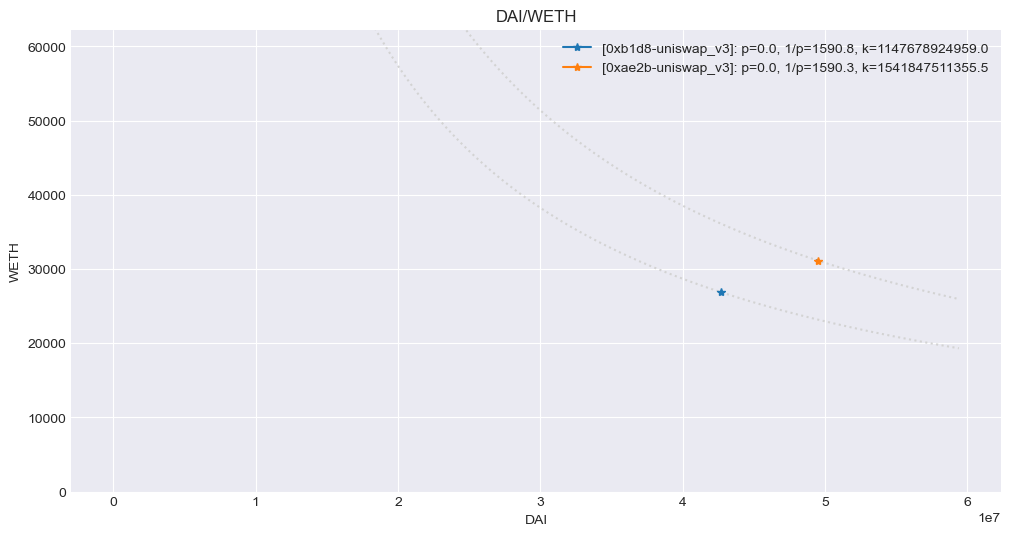

pair = WETH/DAI


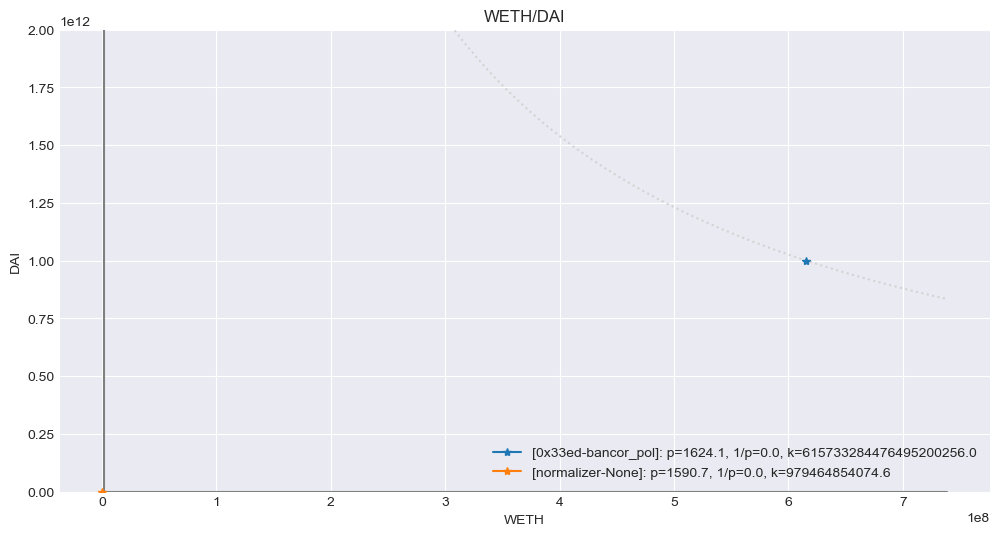

In [53]:
CCn.plot()

pair = WETH/DAI


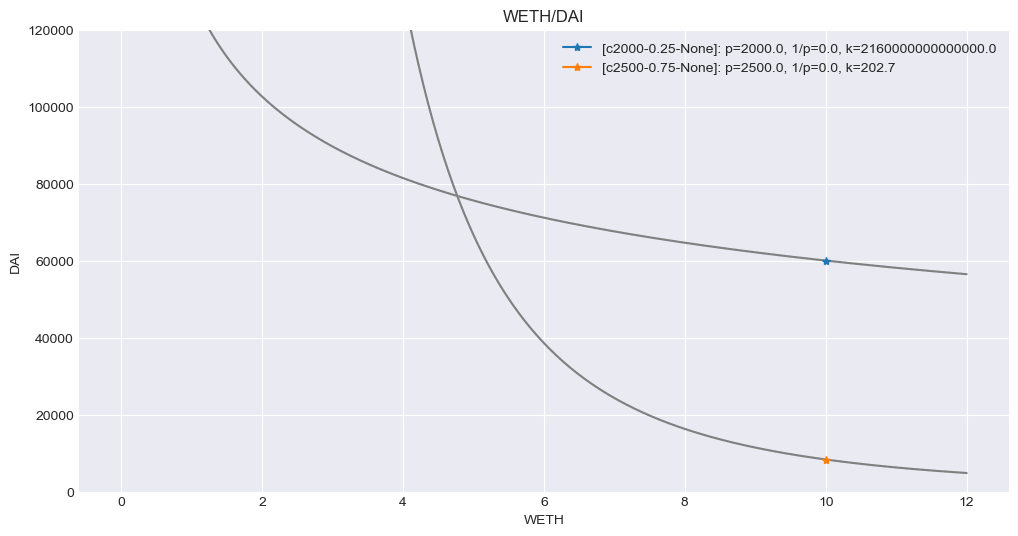

In [54]:
CCas2.plot()

In [55]:
#CCas3.plot()